### [kdegrave.github.io](https://kdegrave.github.io/)

### [Physican360 example codebase](https://github.com/kdegrave/kdegrave.github.io/tree/main/notebooks/Physician360)

### Introduction

Physician reviews are an important source of information for patients seeking healthcare providers online. Mercury Healthcare (formerly Healthgrades) currently has over three million published text reviews on its website. A better understanding of the contents of these reviews and the ability to automatically predict which labels appear in new reviews would allow us to provide a better search experience to patients visiting the Healthgrades website.

The goal of this work was to develop a set of predictive models to automatically label physician reviews with themes derived from a large corpus of online text comments, along with the sentiment associated with those themes. Model performance was compared to baseline values derived using a dictionary-based string matching approach and patient satisfaction rating at the time of review submission.

Six common themes were identified in our dataset: bedside manner, communication, physician skill or quality of care received, staff, visit time, and wait time. Approximately 95% all reviews in our dataset reference at least one of these topics, with 80% of reviews mentioning provider skill or quality of care received. Models were trained on review data labeled using Amazon's Mechanical Turk tool (figure below). Our best predictive models achieve an average unweighted ROC AUC labeling score of 0.914 across the six themes, and an average ROC AUC sentiment score of 0.981. We find that the theme classifier outperforms a simple dictionary-based approach, and sentiment models incorporating both review text and patient star rating together generally perform better than models using either set of features by themselves.


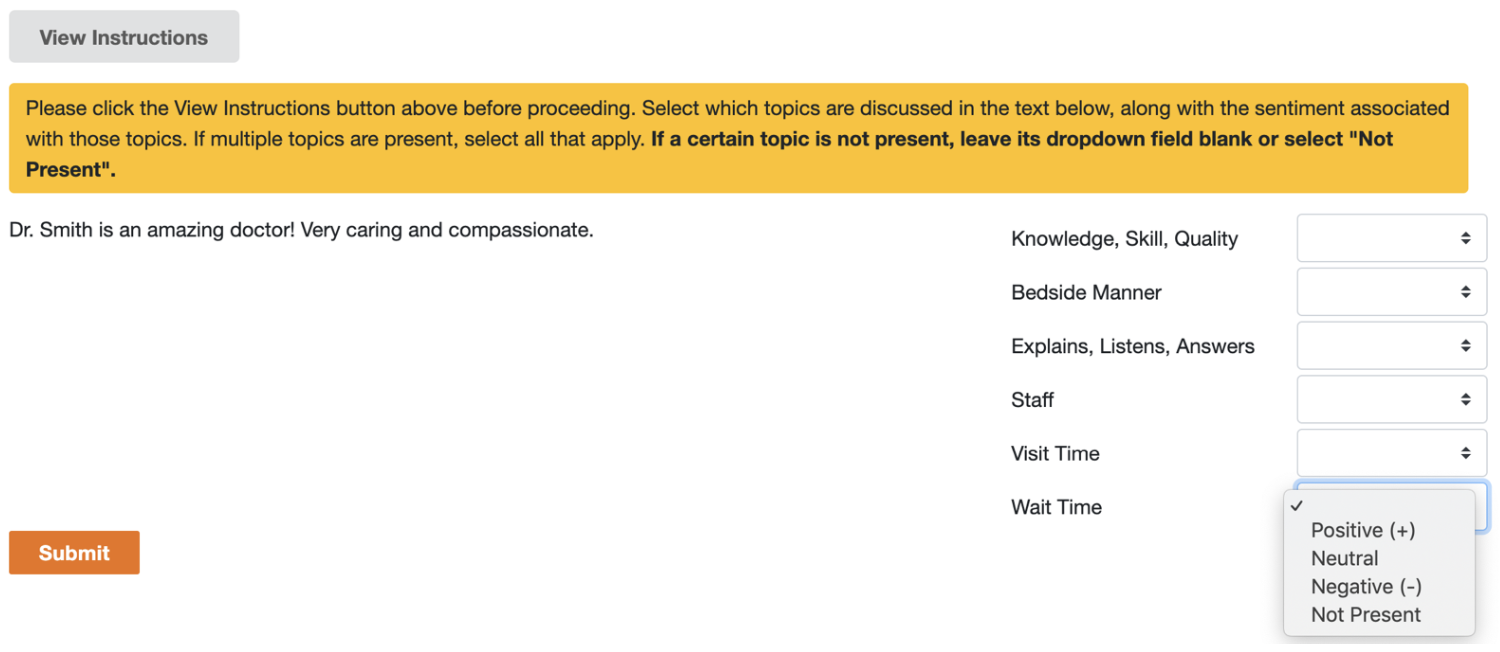

In this notebook we'll step through the model building process for theme identification. An example piece of the project codebase can be found under the link at the top of this notebook. Let's get started by importing some libraries we'll need for the analysis.

In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import gensim.downloader

from matplotlib.pyplot import *
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 500)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.layers import Bidirectional, Embedding
from tensorflow.keras.layers import GRU, SpatialDropout1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

Below we'll define a function to remove punctuation and special characters from the text.

In [5]:
def process_text(text):
    result = text.lower().strip()
    result = re.sub(r'\n', ' ', result)
    result = re.sub(r'\t', ' ', result)
    result = re.sub(r'\r', ' ', result)
    result = re.sub(r'\\+', ' ', result)
    result = re.sub(r'\.+', ' ', result)
    result = re.sub(r'\!+', ' ', result)
    result = re.sub(r'\?+', ' ', result)
    result = re.sub(r'\-+', ' ', result)
    result = re.sub(r'[^\x00-\x7F]+', ' ', result)
    result = re.sub(r'[^\w\s]', '', result)
    result = re.sub(r' +', ' ', result).strip()
    return result

The data reside in eight separate csv files. Let's read each of them in and redefine some column names.

In [6]:
file_id_list = ['3741148', '3741760', '3742390', '3743847', '3745116', '3746169', '3746609', '3749005']

df = pd.DataFrame()

for i in file_id_list:

    df = df.append(pd.read_csv(f'./data/batch_{i}_results.csv'))

In [7]:
df.columns = [i.split('Input.')[-1].split('Answer.')[-1].lower() for i in df.columns]

In [8]:
df = df[df['assignmentstatus'] != 'Rejected'].sort_values('hitid', ascending=False).reset_index(drop=True)

In [9]:
df.rename(columns={'hitid': 'hit_id', 'workerid': 'worker_id', 'usersurveyid': 'survey_id', 'text': 'review_text'}, inplace=True)

### Discard reviews

There were a few cases where only two Mechanical Turk workers labeled a particular review. For this work we wanted each review to be seen by three labelers so that we could break ties in the instances where workers disagreed. We'll get rid of these here.

In [10]:
discard_reviews = df.groupby('hit_id')['hit_id'].count()[lambda x: x < 3].index.tolist()

df = df[~df['hit_id'].isin(discard_reviews)].reset_index(drop=True)

### Define target columns

A previous analysis showed us that a vast majority of reviews referenced at least one of six common themes: the provider's bedside manner, their willingness to listen to the patient and clearly explain complex diagnoses and procedures, their overall perceived knowledge or quality of care, the front office staff, the overall quality of time spent with the provider (i.e., did they feel their time was wasted?), and the appointment wait time. Let's set those target labels here by voting across Mechanical Turk labelers.

In [11]:
target_columns = ['bedside_manner', 'explains_listens_answers', 'knowledge_skill_quality', 'staff', 'visit_time', 'wait_time']

df[target_columns] = df[target_columns].replace({-1: 1, 0: 1})

df[target_columns] = df[target_columns].replace({-2: 0, 2: 0})

In [12]:
tmp = df.groupby('survey_id')[target_columns].sum().reset_index()

tmp[target_columns] = tmp[target_columns].replace({1: 0, 2: 1, 3: 1})

In [13]:
data = df[['survey_id', 'review_text']].merge(tmp, on='survey_id', how='inner').drop_duplicates('survey_id').reset_index(drop=True)

In [14]:
data[target_columns].apply(lambda x: x.value_counts())

,bedside_manner,explains_listens_answers,knowledge_skill_quality,staff,visit_time,wait_time
0,13622,15804,4596,19068,23364,23357
1,10893,8711,19919,5447,1151,1158


We can se that the data are very imbalanced here. For example only about 4.5% of all reviews mention "visit_time" or "wait_time".

### Clean text

Let's apply our pre-processing function to the text.

In [15]:
data = data.dropna(subset=['review_text']).reset_index(drop=True)

In [16]:
data['processed_text'] = data['review_text'].apply(process_text)

### Split into training and test sets

The data are now split into training and test sets. We'll only allot 15% of the data to the test set since the dataset is very small. We need all the training data we can get!

In [17]:
x_tr, x_te, y_tr, y_te = train_test_split(data['processed_text'], data[target_columns], test_size=0.15, random_state=0)

### Tokenize the datasets

Alright, now we can start our model building! We'll use a recurrent neural network model for theme tagging, and this will incorporate pre-trained word vectors from a popular model called Word2Vec. The variables below allow us to specify how many tokens (words) we'll use from each review to classify them (maxlen), the total number of tokens in the model vocabulary (max_features), and the length of the Word2Vec embedding vectors (embedding_size). We'll tokenize the reviews and pad them to the same length.

In [18]:
maxlen = 100
max_features = 20000
embedding_size = 300

In [19]:
tokenizer = Tokenizer(num_words=max_features)

tokenizer.fit_on_texts(data['processed_text'])

In [20]:
x_tr = tokenizer.texts_to_sequences(x_tr)
x_te = tokenizer.texts_to_sequences(x_te)

In [21]:
x_tr = pad_sequences(x_tr, maxlen=maxlen)
x_te = pad_sequences(x_te, maxlen=maxlen)

The gensim package has a nice way to download the word vectors we need. In addition to Word2Vec, we also have access to GloVe and fasttext word embeddings if we so choose.

In [22]:
[i for i in gensim.downloader.info()['models'].keys()]

['fasttext-wiki-news-subwords-300',
 'conceptnet-numberbatch-17-06-300',
 'word2vec-ruscorpora-300',
 'word2vec-google-news-300',
 'glove-wiki-gigaword-50',
 'glove-wiki-gigaword-100',
 'glove-wiki-gigaword-200',
 'glove-wiki-gigaword-300',
 'glove-twitter-25',
 'glove-twitter-50',
 'glove-twitter-100',
 'glove-twitter-200',
 '__testing_word2vec-matrix-synopsis']

We can now vectorize each word in our vocabulary.

In [23]:
embedding_index = gensim.downloader.load('word2vec-google-news-300')

In [24]:
word_index = tokenizer.word_index

num_words = min(max_features, len(word_index)) + 1

embedding_matrix = np.zeros((num_words, embedding_size))

In [25]:
for word, i in word_index.items():
    if i >= max_features:
        break

    try:
        embedding_matrix[i] = embedding_index[word]
    except:
        pass

Before we build the neural network, we'll create a a custom callback to compute the ROC AUC value at the end of each epoch. This will give us another metric to use in order to tell how well the model is fitting our imbalanced dataset. On epoch end, the ROC AUC will be computed on a holdout validation set.

In [26]:
class RocAucEvaluation(Callback):

    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:

            y_pred = self.model.predict(self.X_val, verbose=0)

            score = roc_auc_score(self.y_val, y_pred)

            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch + 1, score))

The model is a bidirectional recurrent neural network built using Keras. We'll use the Adam optimizer with binary crossentropy as our loss.

In [29]:
model = Sequential([

    Embedding(num_words, embedding_size, weights=[embedding_matrix]),

    SpatialDropout1D(0.2),
    Bidirectional(GRU(80, return_sequences=True)),
    GlobalMaxPooling1D(),
    Dense(6, activation='sigmoid')
])

In [30]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
roc_auc = RocAucEvaluation(validation_data=(x_te, y_te), interval=1)

In [320]:
history = model.fit(x_tr, y_tr, batch_size=128, epochs=3, validation_split=0.1, callbacks=[roc_auc])

Epoch 1/3
147/147 [==============================] - ETA: 0s - loss: 0.3611 - accuracy: 0.3722
 ROC-AUC - epoch: 1 - score: 0.884726 

147/147 [==============================] - 51s 335ms/step - loss: 0.3611 - accuracy: 0.3722 - val_loss: 0.2611 - val_accuracy: 0.5192
Epoch 2/3
147/147 [==============================] - ETA: 0s - loss: 0.2336 - accuracy: 0.4775
 ROC-AUC - epoch: 2 - score: 0.918997 

147/147 [==============================] - 48s 323ms/step - loss: 0.2336 - accuracy: 0.4775 - val_loss: 0.2268 - val_accuracy: 0.5216
Epoch 3/3
147/147 [==============================] - ETA: 0s - loss: 0.2062 - accuracy: 0.4826
 ROC-AUC - epoch: 3 - score: 0.923985 

147/147 [==============================] - 45s 307ms/step - loss: 0.2062 - accuracy: 0.4826 - val_loss: 0.2203 - val_accuracy: 0.4861


The callback suggests that the model produces an ROC AUC of about 0.92 averaged across the six classes. Let's apply the model to our test set and see how we did.

In [321]:
predict = model.predict(x_te)

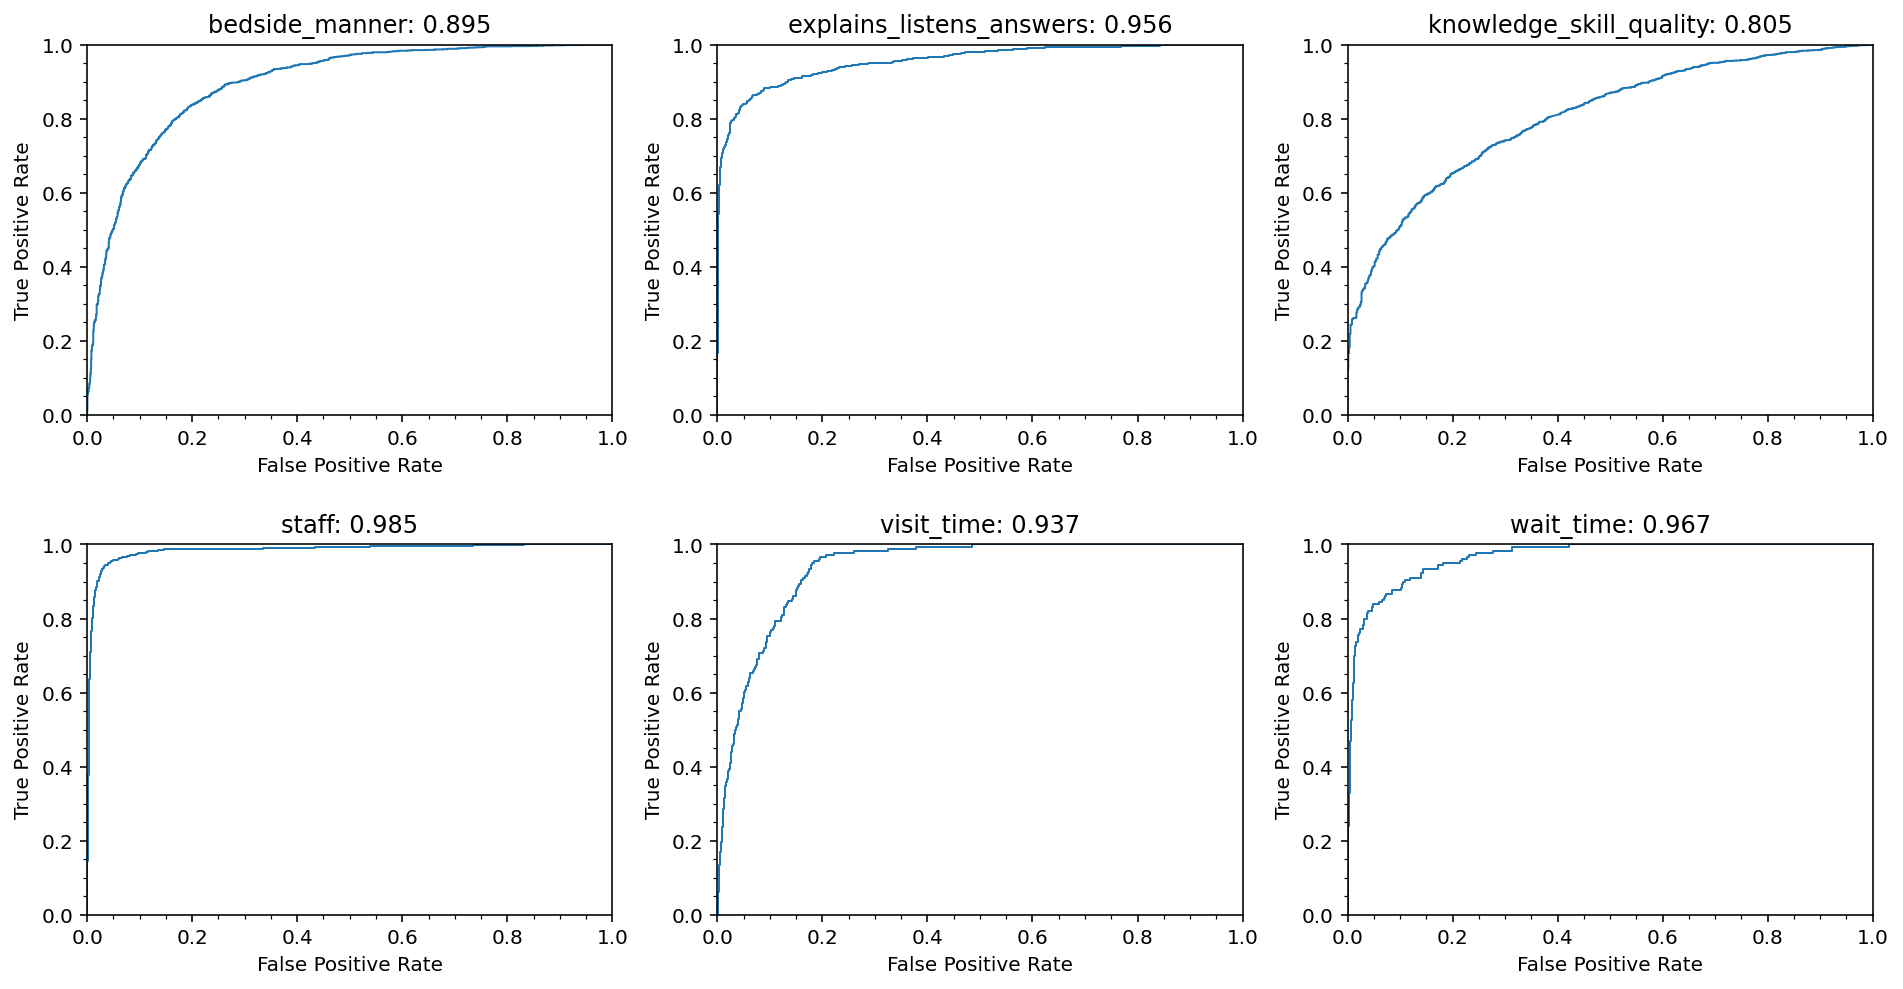

In [400]:
fig, axs = subplots(2, 3, figsize=(16, 8))

fig.subplots_adjust(hspace=0.35)

for i, ax in enumerate(fig.axes):

    fp, tp, threshold = roc_curve(y_te.iloc[:, i], predict[:, i])

    score = roc_auc_score(y_te.iloc[:, i], predict[:, i])

    ax.plot(fp, tp, lw=1)
    ax.minorticks_on()
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 1)
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    ax.set_title(f'{target_columns[i]}: {score.round(3)}')

The models perform quite well overall. Of the six themes, the model has the hardest time understanding when a review references the provider's perceived knowledge or quality of care received. This actually seems to be reflected in the labels given by the Mechanical Turk workers as well. In terms of written text, there are many ways to describe this broad category relative to something like front office staff. Perhaps it would be appropriate to break the category into separate "knowledge, skill" and "quality of care" categories.

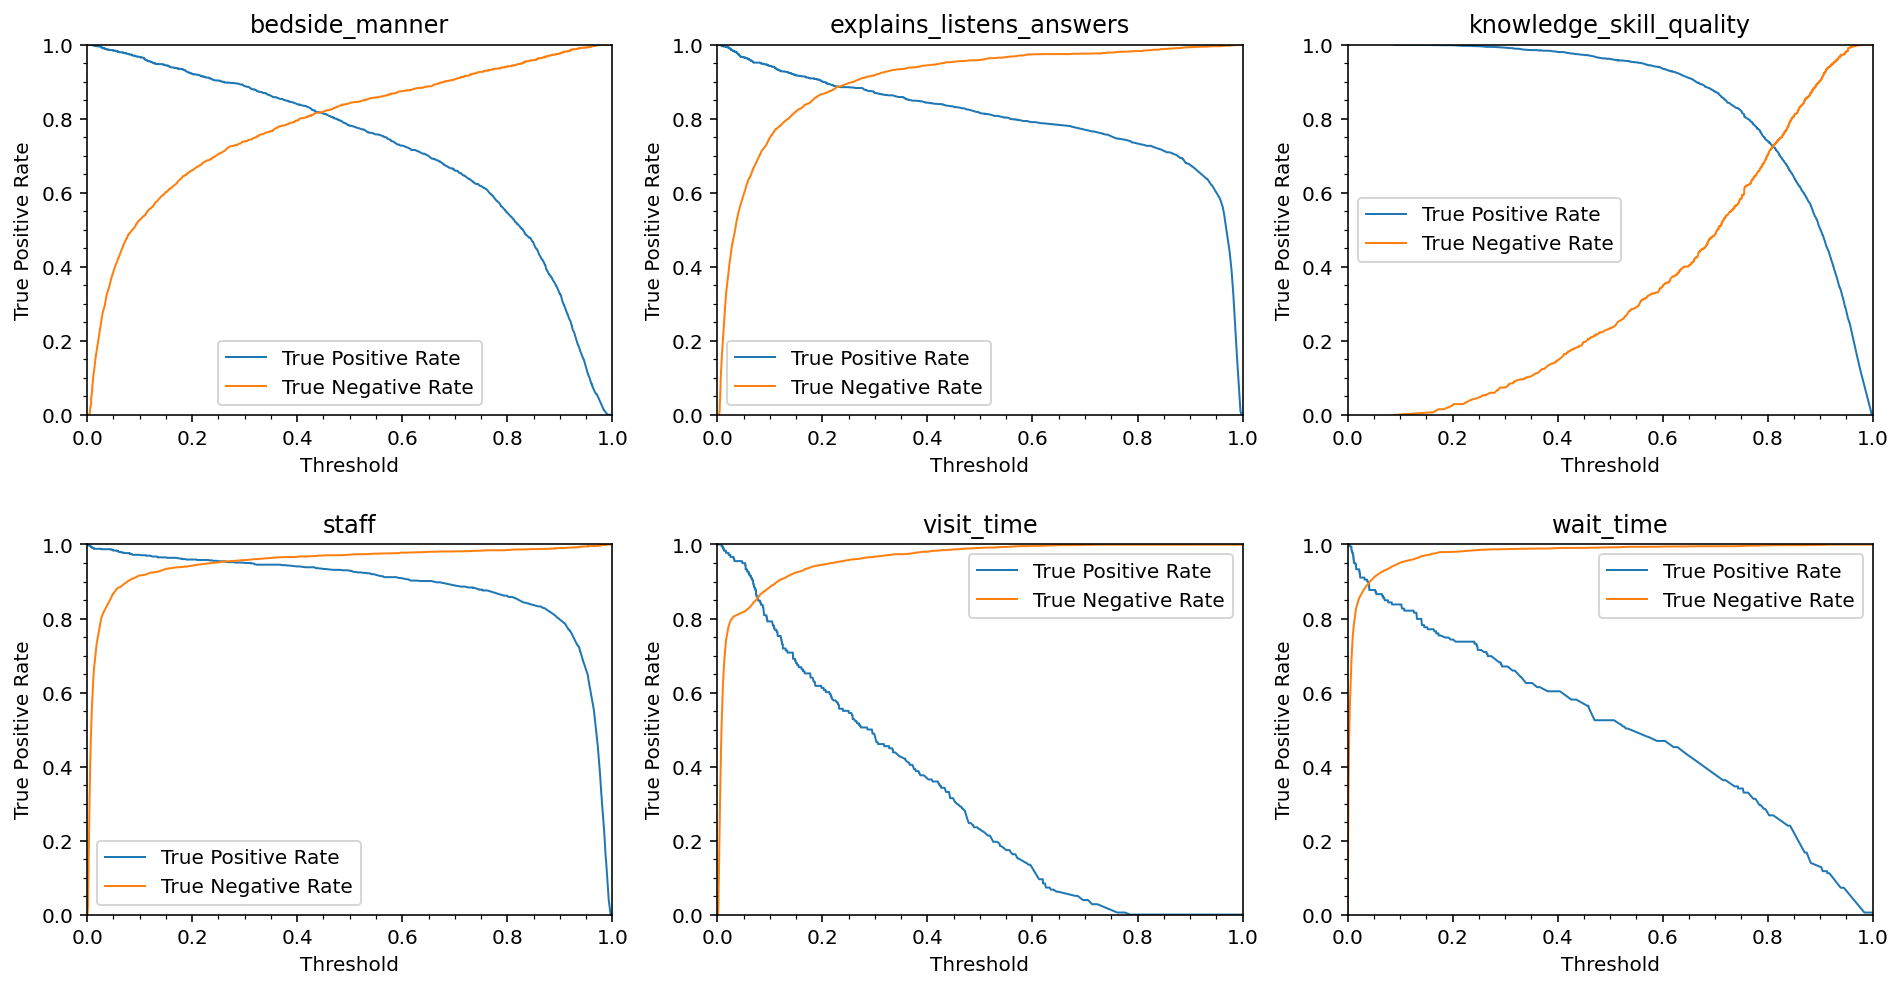

In [403]:
fig, axs = subplots(2, 3, figsize=(16, 8))

fig.subplots_adjust(hspace=0.35)

for i, ax in enumerate(fig.axes):

    fp, tp, threshold = roc_curve(y_te.iloc[:, i], predict[:, i])

    score = roc_auc_score(y_te.iloc[:, i], predict[:, i])

    ax.plot(threshold, tp, lw=1)
    ax.plot(threshold, 1 - fp, lw=1)
    ax.minorticks_on()
    ax.set_ylim(0, 1)
    ax.set_xlim(0, 1)
    ax.set_xlabel('Threshold')
    ax.set_ylabel('True Positive and True Negative Rates')
    ax.legend(['True Positive Rate', 'True Negative Rate'])
    ax.set_title(f'{target_columns[i]}')

Lastly, the figures above show the true positive and true negatives rates as a function of prediction threshold. The threshold value can be tuned in a way that gives us some control over these values, depending on our goals, company objectives, etc.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>